<center><img src="https://www.nationaljewish.org/NJH/media/img/stock/Influenza-Viruses.jpg"/></center>

# Forecasting Zoonotic Outbreaks
In this notebook we will collect the number of outbreaks by country and year, and various statistics on each country by year, and train a few different classification models to derive a "risk score" for each country for each year. First we will do some pre-processing of the data, then we will train and validate the models selecting the most effective one, and lastly we will visualize and validate our results. We also included a section at the end to test your browser to make sure it is compatible with our visualization tools. If your browser is not compatible, not to worry, each interactive cell has an "Important!" cell below it which can be run to get the static version of the same graphs.

Each section will be delineated by the below following headers, but for a more comprehensive glossary we highly recommend you use jupyter lab.
- [Preprocessing](#Preprocessing)
- [Model Training](#Model-Training)
- [Visualizations](#Visualizations)
- [Validating Our Results](#Validating-Our-Results)
- [Test Your Browser](#Test-Your-Browser)

# Preprocessing

In [40]:
%%capture
!pip install pandas
!pip install scipy
!pip install tqdm
# Update path to allow for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm import tqdm

In [2]:
# grabbing number of zoonotic outbreaks by country and year
data_dir = Path("../data")
outbreak = pd.read_csv(data_dir / "raw/OutbreaksData.csv")
outbreak.head()

,Unnamed: 0,Country,iso2,iso3,Year,icd10n,icd103n,icd104n,icd10c,icd103c,icd104c,icd11c1,icd11c2,icd11c3,icd11l1,icd11l2,icd11l3,Disease,DONs,Definition
0,1,Afghanistan,AF,AFG,2000,Arthropod-borne viral fevers and viral haemorr...,Unspecified viral haemorrhagic fever,Unspecified viral haemorrhagic fever,A92-A99,A99,A990,1,D86,1D86,Certain infectious or parasitic diseases,Certain other viral diseases,"Viral haemorrhagic fever, not elsewhere classi...",Unspecified viral haemorrhagic fever,"DON0404, DON0399",NaN
1,2,Afghanistan,AF,AFG,2002,Intestinal infectious diseases,Other gastroenteritis and colitis of infectiou...,Other and unspecified gastroenteritis and coli...,A00-A09,A09,A090,1,A40,1A40,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Gastroenteritis or colitis without specificati...,Infectious gastroenteritis or colitis without ...,DON0607,NaN
2,3,Afghanistan,AF,AFG,1998,Intestinal infectious diseases,Cholera,Classical cholera,A00-A09,A00,A000,1,A00,1A00,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Cholera,"DON0253, DON0249, DON0248",Intestinal infection due to Vibrio cholerae
3,4,Afghanistan,AF,AFG,1999,Codes for special purposes,Provisional assignment of new diseases of unce...,Severe acute respiratory syndrome [SARS],U00-U49,U04,U049,1,D65,1D65,Certain infectious or parasitic diseases,Certain zoonotic viral diseases,Severe acute respiratory syndrome,Severe acute respiratory syndrome,DON0294,"A disease of the respiratory system, caused by..."
4,5,Afghanistan,AF,AFG,2000,Intestinal infectious diseases,Cholera,Classical cholera,A00-A09,A00,A000,1,A00,1A00,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Cholera,DON0413,Intestinal infection due to Vibrio cholerae


In [3]:
# filtering for zoonotic outbreaks
zoonotic = [
    'Unspecified viral haemorrhagic fever',
    'Severe acute respiratory syndrome [SARS]',
    'Influenza due to identified zoonotic or pandemic influenza virus',
    'Dengue, unspecified',
    'Leishmaniasis, unspecified',
    'West Nile virus infection',
    'Plague, unspecified',
    'Middle East respiratory syndrome coronavirus [MERS-CoV]',
    'Yellow fever, unspecified',
    'Hantavirus (cardio-)pulmonary syndrome',
    'Chikungunya virus disease',
    'Listeriosis, unspecified',
    'Legionnaires disease',
    'Acute hepatitis A',
    'Zika virus disease',
    'Lassa fever',
    'Acute hepatitis E',
    'Monkeypox',
    'Leptospirosis, unspecified',
    'Rift Valley fever',
    'Ebola virus disease',
    'Marburg virus disease',
    'Anthrax, unspecified',
    'Rabies, unspecified',
    'Salmonella infection, unspecified',
    'Tularaemia, unspecified',
    'Venezuelan equine fever',
    'Coccidioidomycosis, unspecified',
    'Haemorrhagic fever with renal syndrome',
    'St Louis encephalitis',
    'Bubonic plague'
]
# We are not including covid, just adding an outbreak in China since this was the animal to human part


In [4]:
filtered_df = outbreak[outbreak['icd103n'].isin(zoonotic)]

In [5]:
# Adding just one row for covid
final_outbreak = filtered_df[['Year', 'Country', 'icd103n']]
final_outbreak._append({"Year": 2020, "Country": "China", 'icd103n': 'COVID-19, virus identified'}, ignore_index=True)

,Year,Country,icd103n
0,2000,Afghanistan,Unspecified viral haemorrhagic fever
1,2009,Afghanistan,Influenza due to identified zoonotic or pandem...
2,1998,Afghanistan,Unspecified viral haemorrhagic fever
3,2009,Albania,Influenza due to identified zoonotic or pandem...
4,2009,Algeria,Influenza due to identified zoonotic or pandem...
...,...,...,...
546,2014,Yemen,Severe acute respiratory syndrome [SARS]
547,2009,Zambia,Influenza due to identified zoonotic or pandem...
548,1999,Zimbabwe,Unspecified viral haemorrhagic fever
549,2009,Zimbabwe,Influenza due to identified zoonotic or pandem...


In [6]:
# Grabbing statistics data from world bank
country_data_raw = pd.read_csv(data_dir / "raw"/ "country_data.csv")
country_data_raw.columns

Index(['Series Name', 'Series Code', 'Country Name', 'Country Code',
       '1960 [YR1960]', '1961 [YR1961]', '1962 [YR1962]', '1963 [YR1963]',
       '1964 [YR1964]', '1965 [YR1965]', '1966 [YR1966]', '1967 [YR1967]',
       '1968 [YR1968]', '1969 [YR1969]', '1970 [YR1970]', '1971 [YR1971]',
       '1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]',
       '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]',
       '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]',
       '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]',
       '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]', '1991 [YR1991]',
       '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]',
       '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
       '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
       '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]',
       '2008 [YR2008]', '2009 [

In [7]:
# The original was a .xlsx with extra info so we need to do some preprocessing for this
filtered_columns = ['Series Name', 'Country Name', '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
       '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
       '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]',
       '2008 [YR2008]', '2009 [YR2009]', '2010 [YR2010]', '2011 [YR2011]',
       '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]',
       '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]',
       '2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]']
country_data = country_data_raw[filtered_columns].iloc[:-5] # Getting rid of data description at the bottom

In [8]:
def convert_values(series):
    return [np.nan if num == '..' else pd.to_numeric(num) for num in series]

In [9]:
# Converting strings to nan so we can interpolate later
dropped_cols = ['Series Name', 'Country Name'] 
df_subset = country_data.drop(columns=dropped_cols)
df_filled = df_subset.apply(convert_values)
print("Converted non numerics to nan")
country_final = pd.concat([country_data[dropped_cols], df_filled], axis=1)
country_final.head()

Converted non numerics to nan


,Series Name,Country Name,1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,"Completeness of birth registration, rural (%)",Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.3,...,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Completeness of birth registration, rural (%)",Africa Eastern and Southern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Completeness of birth registration, rural (%)",Africa Western and Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Completeness of birth registration, rural (%)",Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,98.4,NaN,NaN,NaN,NaN
4,"Completeness of birth registration, rural (%)",Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.5,NaN,NaN,NaN,NaN,NaN,99.6,NaN,NaN,NaN


In [10]:
# We want all outbreaks for a given year. Later we just want a binary classification so 2 outbreaks will become 1.
final_outbreak_ml = final_outbreak[['Year', 'Country']]
final_outbreak_ml = final_outbreak_ml.groupby(['Country', 'Year']).size().unstack(fill_value=0)
final_outbreak_ml.head()                                     

Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Albania,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Algeria,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
American Samoa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Andorra,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Normalize the two tables so that the years and countries match up

In [11]:
# Countries are named differtly so let's make sure they are the same
countries1 = np.array([str(country) for country in country_final['Country Name'].unique()])
countries2 = np.array(final_outbreak_ml.index)

In [12]:
np.setdiff1d(countries2, countries1)

array(['Bahamas', 'Bolivia (Plurinational State of)',
       'Bonaire Sint Eustatius and Saba', 'Congo',
       'Congo Democratic Republic of the', 'Cook Islands', 'Curaçao',
       "Côte d'Ivoire", 'Egypt', 'Falkland Islands (Malvinas)',
       'French Guiana', 'Guadeloupe', 'Guernsey', 'Hong Kong',
       'Iran (Islamic Republic of)', 'Jersey',
       "Korea (Democratic People's Republic of)", 'Korea Republic of',
       "Lao People's Democratic Republic", 'Martinique',
       'Micronesia (Federated States of)', 'Moldova Republic of',
       'Palestine State of', 'Réunion', 'Saint Kitts and Nevis',
       'Saint Lucia', 'Saint Martin (French part)',
       'Saint Vincent and the Grenadines', 'Slovakia',
       'Tanzania United Republic of', 'Turkey',
       'United Kingdom of Great Britain and Northern Ireland',
       'United States of America', 'Venezuela (Bolivarian Republic of)',
       'Viet Nam', 'Virgin Islands (British)', 'Wallis and Futuna',
       'Yemen'], dtype=object)

In [13]:
# Since "countries with outbreaks" is a subset of "countries" we will use the former table for the names
def update_name(name):
    lookup = {
        "Bolivia (Plurinational State of)": "Bolivia",
        "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
        "Turkey": "Turkiye",
        "United States of America": "United States",
        "Viet Nam": "Vietnam",
        "Yemen": "Yemen, Rep.",
        "Egypt": "Egypt, Arab Rep.",
        "Hong Kong": "Hong Kong SAR, China",
        "Iran (Islamic Republic of)": "Iran, Islamic Rep.",
        "Venezuela (Bolivarian Republic of)": "Venezuela, RB",
        "Congo Democratic Republic of the": "Congo, Dem. Rep.",
        "Korea Republic of": "Korea, Rep."
    }
    if name in lookup:
        return lookup[name]
    return name

final_outbreak_ml.index = pd.Series(final_outbreak_ml.index).apply(update_name)

In [14]:
# Subset world data for only countries with outbreaks
country_norm = country_final[country_final['Country Name'].isin(final_outbreak_ml.index)]
outbreak_norm = final_outbreak_ml.loc[country_norm['Country Name'].unique()]

## Merging the two tables together
Now that the tables have the same countries, we can try to merge them together

In [15]:
# Making sure the columns have the same names and years
country_long = country_norm.melt(id_vars=["Series Name", "Country Name"], var_name="year", value_name="value")
def extract_year(year_str):
    return year_str.split(" ")[0]
country_long['year'] = country_long['year'].apply(extract_year)
country_long.head()

,Series Name,Country Name,year,value
0,"Completeness of birth registration, rural (%)",Afghanistan,1996,NaN
1,"Completeness of birth registration, rural (%)",Albania,1996,NaN
2,"Completeness of birth registration, rural (%)",Algeria,1996,NaN
3,"Completeness of birth registration, rural (%)",American Samoa,1996,NaN
4,"Completeness of birth registration, rural (%)",Andorra,1996,NaN


### Dealing with np.nan
A lot of these values are missing so in order to preserve trends, we want to fill in all of the values for a country and statstic to be the mean of that statistic for that country. Otherwise label it as 0 so that it is not weighted in the model.

In [16]:
means = country_long.groupby(['Series Name', 'Country Name'])['value'].transform('mean')
# If there is a mean, fill in all the na's with that mean
country_long['value'] = country_long['value'].fillna(means)
# Otherwise, fill all blank values with 0
country_long['value'] = country_long['value'].fillna(0)

In [17]:
# Country data with interpolation
country_long.head(10)

,Series Name,Country Name,year,value
0,"Completeness of birth registration, rural (%)",Afghanistan,1996,24.466667
1,"Completeness of birth registration, rural (%)",Albania,1996,98.266667
2,"Completeness of birth registration, rural (%)",Algeria,1996,99.433333
3,"Completeness of birth registration, rural (%)",American Samoa,1996,0.000000
4,"Completeness of birth registration, rural (%)",Andorra,1996,0.000000
5,"Completeness of birth registration, rural (%)",Angola,1996,19.700000
6,"Completeness of birth registration, rural (%)",Antigua and Barbuda,1996,0.000000
7,"Completeness of birth registration, rural (%)",Argentina,1996,0.000000
8,"Completeness of birth registration, rural (%)",Armenia,1996,98.100000
9,"Completeness of birth registration, rural (%)",Aruba,1996,0.000000


In [18]:
# Shaping the outbreak data
outbreak_long = outbreak_norm.reset_index().rename(columns={"index":"Country"})
outbreak_long.head()

Year,Country,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albania,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Algeria,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,American Samoa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Andorra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Lastly, make sure the column names match exactly
outbreak_long = outbreak_long.reset_index(drop=True)
outbreak_long = outbreak_long.melt(id_vars="Country", var_name="Year", value_name="Outbreaks")
outbreak_long["Value"] = outbreak_long["Outbreaks"]
outbreak_long["Statistic"] = ["Outbreaks" for num in outbreak_long["Value"]]
outbreak_long.drop(columns=["Outbreaks"], inplace=True)
outbreak_long.head()

,Country,Year,Value,Statistic
0,Afghanistan,1996,0,Outbreaks
1,Albania,1996,0,Outbreaks
2,Algeria,1996,0,Outbreaks
3,American Samoa,1996,0,Outbreaks
4,Andorra,1996,0,Outbreaks


In [20]:
# Make sure country data has the same column names
country_long.columns = ["Statistic", "Country", "Year", "Value"]

In [21]:
# Our final training dataset
training_df = pd.concat([outbreak_long, country_long])
training_df['Year'] = training_df['Year'].astype(int)
training_df.head()

,Country,Year,Value,Statistic
0,Afghanistan,1996,0.0,Outbreaks
1,Albania,1996,0.0,Outbreaks
2,Algeria,1996,0.0,Outbreaks
3,American Samoa,1996,0.0,Outbreaks
4,Andorra,1996,0.0,Outbreaks


## Add adjacency column
Outbreaks don't occur very often so we want there to be some representation of adjacency in the data, especially since we are training each year independently. We want to add a column to capture this.

In [22]:
# Making new dataframe with adjacency column
outbreak_df = training_df[training_df['Statistic'] == 'Outbreaks']
new_df = pd.DataFrame({"Country": outbreak_df["Country"], "Year": outbreak_df["Year"], "Value": np.zeros(len(outbreak_df)), "Statistic": ["Recent Outbreak"] * len(outbreak_df)})
only_outbreaks = outbreak_df[outbreak_df['Value'] > 0]

# function for the year range, if there is an outbreak in a year then we don't necessarily have recent outbreak be true
# otherwise the model might weigh it unusually highly
def generate_numbers(input_number):
    return [i for i in range(input_number + 1, min(input_number + 6, 2023))]
    
for row in tqdm(only_outbreaks.itertuples(index=False)):
    years = generate_numbers(row.Year)
    country = row.Country
    new_df.loc[(new_df['Year'].isin(years)) & (new_df['Country'] == country), 'Value'] = 1

combined = pd.concat([training_df, new_df])

509it [00:00, 3263.32it/s]


## Pivot table for ML training
Typically ML classes require us to have a few series that represent the training features, and one column for the target feature. For this we need to make a pivot table where each row is a country/year pair, and the columns are the values of the statistics

In [23]:
combined["Country_Year"] = combined["Country"] + "_" + combined["Year"].astype(str)
pivot_df = combined.pivot(index=["Country_Year"], columns="Statistic", values="Value")
pivot_df.index.name = None
pivot_df.head()

Statistic,"Completeness of birth registration, rural (%)","Hospital beds (per 1,000 people)",Human capital index (HCI) (scale 0-1),"Human capital index (HCI), male (scale 0-1)",Low-birthweight babies (% of births),"Number of surgical procedures (per 100,000 population)",Outbreaks,People practicing open defecation (% of population),People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population),People using safely managed sanitation services (% of population),People with basic handwashing facilities including soap and water (% of population),"Physicians (per 1,000 people)",Prevalence of undernourishment (% of population),Recent Outbreak,Rural population (% of total population),Rural population growth (annual %),Rural poverty headcount ratio at national poverty lines (% of rural population),"Specialist surgical workforce (per 100,000 population)"
Afghanistan_1996,24.466667,0.432222,0.394258,0.403766,0.0,229.0,0.0,17.557965,52.439123,37.452266,0.0,41.150033,0.229435,28.615,0.0,78.286,3.988129,0.0,0.03
Afghanistan_1997,24.466667,0.432222,0.394258,0.403766,0.0,229.0,0.0,17.557965,52.439123,37.452266,0.0,41.150033,0.110000,28.615,0.0,78.195,3.794297,0.0,0.03
Afghanistan_1998,24.466667,0.432222,0.394258,0.403766,0.0,229.0,1.0,17.557965,52.439123,37.452266,0.0,41.150033,0.229435,28.615,0.0,78.105,3.767769,0.0,0.03
Afghanistan_1999,24.466667,0.432222,0.394258,0.403766,0.0,229.0,0.0,17.557965,52.439123,37.452266,0.0,41.150033,0.229435,28.615,1.0,78.014,3.961297,0.0,0.03
Afghanistan_2000,24.466667,0.300000,0.394258,0.403766,0.0,229.0,1.0,25.968485,27.441856,20.970919,0.0,41.150033,0.229435,28.615,1.0,77.922,1.325806,0.0,0.03


# Model Training

We are going to train a few classification models to see which fits the data the best. If the initial results look good, we will move onto k-fold validation and if the results still look good we will do a grid search to determine the best hyperparameters for the model. The grid search will use timeseries cross validation so that we don't risk data leakage.

## Random Forest Classifier

In [24]:
%%capture
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_val_predict

In [25]:
pivot_df['Outbreaks'] = (pivot_df['Outbreaks'] > 0).astype(int) # setting this up as a binary classification problem

# split up our features and target, and add standard scaling
scaler = StandardScaler()
pivot_df['Year'] = [int(str(idx).split('_')[-1]) for idx in pivot_df.index]
pivot_df.sort_values(by='Year', inplace=True) # needed for timeseries split
pivot_df.drop('Year', axis=1, inplace=True)

X = pivot_df.drop('Outbreaks', axis=1)
X = scaler.fit_transform(X)
y = pivot_df['Outbreaks']

tscv = TimeSeriesSplit(n_splits=5)

clf = RandomForestClassifier(random_state=42)

accuracy_scores = cross_val_score(clf, X, y, cv=tscv, scoring='accuracy')
precision_scores = cross_val_score(clf, X, y, cv=tscv, scoring='precision')

# Evaluate the model
print("Cross-validated accuracy mean:", np.mean(accuracy_scores))
print("Std of cross-validated accuracy:", np.std(accuracy_scores))
print("Cross-validated precision mean:", np.mean(precision_scores))
print("Std of cross-validated precision:", np.std(precision_scores))

Cross-validated accuracy mean: 0.8449748743718593
Std of cross-validated accuracy: 0.08963759316622473
Cross-validated precision mean: 0.3185887975261789
Std of cross-validated precision: 0.10737475409013986


These results appear to be decent. Of course, it's not very accurately predicting when there will be an outbreak, but that is because only a small fraction of outbreaks occur in each country in each year, so it's understandable that when it **does** predict an outbreak, there is a low likelihood that it is correct. Since it seems decent, we will test the results of this model more thoroughly.

### Random Forest Classifier Validation
Our results look pretty good! Let's make sure we are getting the best results possible by implementing a grid search for parameter tuning. For this we will use f1 score as our scoring metric because we assume that there are very few "actual" positive classifications and so accuracy or precision alone might lead to an imbalanced classification model. Also, we will continue to use timeseries splitting to prevent data leakage.

In [26]:
# Defining the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}

rf = RandomForestClassifier(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(rf, param_grid, cv=tscv)

grid_search.fit(X, y)
best_rf_classifier = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Best Score: 0.856281407035176


### Forest Results
Looks like we do decently considering the dataset. Next we are going to see how our model stacks up against a basic logistic regression model. This will serve as a sort of "baseline" for our results.

## Logistic Regression
In this section I trained the logistic regression model and evaluated with the timeseries split. However, I noticed something odd while looking at the numbers so the code I've included is just my debugging of the issue.

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
%%capture --no-stdout
tscv = TimeSeriesSplit(n_splits=5)

log_reg = LogisticRegression(random_state=42, max_iter=1000, C=1.0, solver='lbfgs')

accuracies = []
classification_reports = []

# Time series cross-validation + storing scores
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    log_reg.fit(X_train, y_train)

    y_pred = log_reg.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_pred))
    classification_reports.append(classification_report(y_test, y_pred))

In [29]:
print("Average Accuracy:", np.mean(accuracies))
print("Classification Report for the first fold:\n", classification_reports[0])

Average Accuracy: 0.8768844221105528
Classification Report for the first fold:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       708
           1       0.00      0.00      0.00        88

    accuracy                           0.89       796
   macro avg       0.44      0.50      0.47       796
weighted avg       0.79      0.89      0.84       796



In [30]:
# Uh oh... why is precision so low?
(y_pred > 0.5).sum()

0

Well that's not good... it seems to get a high score because it assumes that there will be no outbreaks at all... ever. This is understandable because of all the years and countries, very few have outbreaks. This might be improved with some tuning but at this point I think we should not use this model.

## KNearest Neighbor

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Perform time series cross-validation
accuracy_scores = cross_val_score(knn, X, y, cv=tscv)
precision_scores = cross_val_score(knn, X, y, cv=tscv, scoring='precision')

# Output results
print(f"Accuracy Scores: {accuracy_scores}")
print(f"Mean accuracy Score: {np.mean(accuracy_scores)}")
print(f"Standard Deviation of accuracy Scores: {np.std(accuracy_scores)}")

print(f"Precision Scores: {precision_scores}")
print(f"Mean precision Score: {np.mean(precision_scores)}")
print(f"Standard Deviation of precision Scores: {np.std(precision_scores)}")



Accuracy Scores: [0.88693467 0.76256281 0.78266332 0.87437186 0.96859296]
Mean accuracy Score: 0.8550251256281406
Standard Deviation of accuracy Scores: 0.07493421102149946
Precision Scores: [0.25       0.17647059 0.37837838 0.17391304 0.42857143]
Mean precision Score: 0.2814666877326724
Standard Deviation of precision Scores: 0.10451200916639199


Hey this is actually (marginally) better than our random forest regressor! Let's continue the analysis by using k fold cross validation. Since this is our best model yet, let's also see if we can do some hyperparameter tuning to improve the evaluation statistics. For this we will use f1 score as our scoring metric because we assume that there are very few "actual" positive classifications and so accuracy or precision alone might lead to an imbalanced classification model.

In [33]:
param_grid = {
    'n_neighbors': [2, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# evaluate the best one
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best Score: 0.8684372300650052
Test Set Accuracy: 0.9698492462311558
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       774
           1       0.46      0.50      0.48        22

    accuracy                           0.97       796
   macro avg       0.72      0.74      0.73       796
weighted avg       0.97      0.97      0.97       796



## Evaluation Results
It looks like a k nearest neighbor model with manhattan metric, 7 nearest neighbors, and a uniform weight is our most effective model. That said, let's use our best model's predicted probabilities as a sort of "risk score" so that we can use it to visualize the results and predict the trend of outbreaks for each country.

## Shaping Results for Visualizations
Ideally we want a dataframe that is just Country, Year, and Score so that we can fit it onto a map. We also want to apply linear regression to each country to predict the risk score in the next 5 years. We'll do that below before diving into making the visualizations

In [34]:
prob_scores = [tup[1] for tup in best_knn.predict_proba(X)]
pivot_df['Risk Score'] = prob_scores
pivot_df = pivot_df.reset_index()

In [35]:
pivot_df[['Country', 'Year']] = pivot_df['index'].str.split('_', expand=True)

final_df = pivot_df[['Year', 'Country', 'Risk Score']].copy()
final_df['Year'] = final_df['Year'].astype(int)

In [36]:
%%capture
from sklearn.linear_model import LinearRegression

risk_trends = {'Country': [], 'Trends': []} # Saving this for later comparison
future_predictions = pd.DataFrame()

for country in final_df['Country'].unique():
    country_data = final_df[final_df['Country'] == country]
    model = LinearRegression()
    X = country_data[['Year']]
    y = country_data['Risk Score']
    model.fit(X, y)
    risk_trends['Country'].append(country)
    risk_trends['Trends'].append(model.coef_[0])  # getting trend direction for later

    # Looking at the next 5 years
    future_years = np.array([[year] for year in range(2023, 2028)])
    predicted_scores = model.predict(future_years)

    # This is the temp dataframe for the predictions
    predictions_df = pd.DataFrame({
        'Year': range(2023, 2028),
        'Country': [country] * 5,
        'Risk Score': predicted_scores
    })

    # Append predictions to the future_predictions DataFrame
    future_predictions = pd.concat([future_predictions, predictions_df], ignore_index=True)

# Concatenate future predictions with original data
risk_trend_df = pd.DataFrame(risk_trends)
final_df = pd.concat([final_df, future_predictions], ignore_index=True)
final_df.loc[final_df['Risk Score'] < 0, 'Risk Score'] = 0

In [37]:
# Checking that the extra years are added
final_df[(final_df['Country'] == 'Afghanistan') & (final_df['Year'] > 2020)]

,Year,Country,Risk Score
4449,2021,Afghanistan,0.142857
4606,2022,Afghanistan,0.142857
4779,2023,Afghanistan,0.155474
4780,2024,Afghanistan,0.153730
4781,2025,Afghanistan,0.151986
4782,2026,Afghanistan,0.150241
4783,2027,Afghanistan,0.148497


# Visualizations

In [38]:
%%capture
!pip install plotly
import ipywidgets as widgets
from IPython.display import display
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

## Country Names
We still need to make sure that our country names match the country names that are expected by the graphing library. Luckily we have a dictionary of the format {code: country} so we will import this, look for differences, and correct the mismatches. 

In [41]:
from src.data_processing.iso_dict import iso_codes

In [42]:
country_codes = {v: k for k, v in iso_codes.items()}

In [43]:
# report mismatches
bad_countries = []
for country in final_df['Country'].unique():
    if country not in country_codes:
        bad_countries.append(country)

print(bad_countries)

['Eswatini', 'Egypt, Arab Rep.', 'Venezuela, RB', 'Congo, Dem. Rep.', 'United States', 'Sint Maarten (Dutch part)', 'Iran, Islamic Rep.', 'Syrian Arab Republic', 'Turkiye', 'North Macedonia', 'Cabo Verde', 'Hong Kong SAR, China', 'Czechia', 'Kosovo', 'Korea, Rep.', 'Yemen, Rep.', 'Virgin Islands (U.S.)', 'Vietnam']


In [44]:
correct_countries = {
    'Cabo Verde': 'CPV',
    'Congo, Dem. Rep.': 'COD',
    'Czechia': 'CZE',
    'Egypt, Arab Rep.': 'EGY',
    'Eswatini': 'SWZ',
    'Hong Kong SAR, China': 'HKG',
    'Iran, Islamic Rep.': 'IRN',
    'Korea, Rep.': 'KOR',
    'Kosovo': 'XKX',  # Note: Kosovo uses the "XKX" code as it is not universally recognized
    'North Macedonia': 'MKD',
    'Sint Maarten (Dutch part)': 'SXM',
    'Syrian Arab Republic': 'SYR',
    'Turkiye': 'TUR',
    'United States': 'USA',
    'Venezuela, RB': 'VEN',
    'Vietnam': 'VNM',
    'Virgin Islands (U.S.)': 'VIR',
    'Yemen, Rep.': 'YEM',
}


In [45]:
final_df = final_df[final_df['Country'] != 0] # pretty sure this is just a null entry
country_codes.update(correct_countries)
final_df['Country'] = [country_codes[country] for country in final_df['Country']]

In [46]:
final_df.head()

,Year,Country,Risk Score
0,1996,AFG,0.285714
1,1996,MLI,0.142857
2,1996,GBR,0.000000
3,1996,AUS,0.000000
4,1996,CHL,0.000000


## Heatmap

In [47]:
%%capture
!pip install pandas plotly ipywidgets
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
pyo.init_notebook_mode(connected=True)

In [48]:
# Aggregate data function for the printout
viz_df = final_df.copy()
def get_top_countries_by_year_and_decade(year):
    # Filter the dataframe for the given year and sort by score
    top_countries_year = viz_df[viz_df['Year'] == year].sort_values(by='Risk Score', ascending=False).head(5)['Country'].tolist()

    # Get decade
    decade_start = year - (year % 10)
    decade_end = decade_start + 9

    # Calculate average scores for decade
    df_decade = viz_df[(viz_df['Year'] >= decade_start) & (viz_df['Year'] <= decade_end)]
    avg_risk_scores = df_decade.groupby('Country')['Risk Score'].mean().sort_values(ascending=False)
    top_countries_decade = avg_risk_scores.head(5).index.tolist()

    return [iso_codes[country] for country in top_countries_year], [iso_codes[country] for country in top_countries_decade]


In [67]:
viz_df.head()
viz_df['Risk Score'] = viz_df['Risk Score'].apply(lambda x: x if x<=1 else 1)
viz_df.to_pickle("../data/processed/heatmap_df.pkl")

In [ ]:
import plotly.express as px

def create_heatmap(year):
    filtered_df = viz_df[viz_df['Year'] == year]
    
    fig = px.choropleth(
        filtered_df,
        locations="Country",
        color="Risk Score",
        hover_name="Country",
        color_continuous_scale=px.colors.sequential.Plasma,
        locationmode='ISO-3',
        range_color=(0, 1)
    )
    fig.update_layout(
        title={
            'text': f'Risk Score Heatmap for {year}',
            'x': 0.5,
            'xanchor': 'center'
        },
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='equirectangular'
        ),
        width=800,
        height=600
    )
    fig.show()


In [ ]:
import ipywidgets as widgets
from IPython.display import display


# Assuming df is your DataFrame and it has a 'Year' column
year_slider = widgets.IntSlider(
    value=2023, min=1996, max=2027, step=1,
    description='Year:', continuous_update=True
)

# Output widget
output = widgets.Output()

# Callback function using output widget
def on_year_change(change):
    with output:
        output.clear_output(wait=True)  # Clear previous output
        create_heatmap(change.new)  # Generate new output
        top_countries_year, top_countries_decade = get_top_countries_by_year_and_decade(change.new)
        decade = change.new - (change.new % 10)
        print(f"Top 5 Highest Risk Countries of {decade} - {decade+10}\n")
        for i in range(1, 6):
            print(f"{i} - {top_countries_decade[i-1]}")
        print(f"\nTop 5 Highest Risk Countries for {change.new}\n")
        for i in range(1, 6):
            print(f"{i} - {top_countries_year[i-1]}")
            

# Observe slider changes
year_slider.observe(on_year_change, names='value')

# Display widgets
display(year_slider, output)
create_heatmap(2023)

## Important!
If the visualization above isn't working for you for whatever reason, please run the below code to get a set of static graphs which summarize the trends shown by the interactive tool.

In [ ]:
for year in [1996, 2022, 2027]:
    create_heatmap(year)
    top_countries_year, top_countries_decade = get_top_countries_by_year_and_decade(year)
    decade = year - (year % 10)
    print(f"Top 5 Highest Risk Countries of {decade} - {decade+10}\n")
    for i in range(1, 6):
        print(f"{i} - {top_countries_decade[i-1]}")
    print(f"\nTop 5 Highest Risk Countries for {year}\n")
    for i in range(1, 6):
        print(f"{i} - {top_countries_year[i-1]}")
            

# Validating Our Results

After all this analysis a reasonable counterpoint could be: **Does all this extra data actually add anything? Couldn't I just use the number of past outbreaks to show the trend for the future number of outbreaks?** This is certainly possible, so in this section we will provide plots for both risk score over time, and outbreaks over time. The latter will only use a a linear regression model fitted to the number of past outbreaks by year. Then, we will show all of the countries in our model that defy the trajectory of the linear regression model. If there are no differences, then our model is just picking up on the trend of the number of past outbreaks. If there are differences, then our model could be picking up on larger trends. It is important to note that we are not comparing the efficacy of each model in categorizing a year/country as having an outbreak or not since there a generally very few outbreaks in a country in a given year (usually zero) so we just want to looks at the trend of each country. 

In [50]:
# We need a df with outbreaks, country, and year
outbreaks_df = pivot_df[['Year', 'Country', 'Outbreaks']]
outbreaks_df.loc[outbreaks_df['Outbreaks'] > 0, 'Outbreaks'] = 1

In [51]:
outbreaks_df.head()

Statistic,Year,Country,Outbreaks
0,1996,Afghanistan,0
1,1996,Mali,0
2,1996,United Kingdom,0
3,1996,Australia,0
4,1996,Chile,0


## Comparing to Baseline

In [52]:
%%capture
# Using logistic regression to predict outbreaks
future_predictions = pd.DataFrame()
outbreak_trends = {'Country': [], 'Trend': []}

# Iterate over each country
for country in outbreaks_df['Country'].unique():
    country_data = outbreaks_df[outbreaks_df['Country'] == country]
    model = LogisticRegression()
    X = country_data[['Year']]
    y = country_data['Outbreaks']
    model.fit(X, y)
    outbreak_trends['Country'].append(country)
    outbreak_trends['Trend'].append(model.coef_[0][0]) # coefficient for year

    future_years = np.array([[year] for year in range(2023, 2028)])
    predicted_scores = model.predict(future_years)

    # temp dataframe for the predictions
    predictions_df = pd.DataFrame({
        'Year': range(2023, 2028),
        'Country': [country]*5,
        'Outbreaks': predicted_scores
    })

    # append predictions to the future_predictions DataFrame
    future_predictions = pd.concat([future_predictions, predictions_df], ignore_index=True)

# Concatenate future predictions with original data
outbreak_trend_df = pd.DataFrame(outbreak_trends)
outbreak_final = pd.concat([outbreaks_df, future_predictions], ignore_index=True)

In [53]:
# Some preprocessing
new_codes = {v: k for k, v in country_codes.items()}
def get_name_from_code(name):
    return new_codes[name]

df1 = final_df.copy()
df1['Country'] = df1['Country'].apply(get_name_from_code)
df2 = outbreak_final.copy()

In [54]:
df1['Year'] = pd.to_numeric(df1['Year'], errors='coerce')
df2['Year'] = pd.to_numeric(df2['Year'], errors='coerce')
df1.to_pickle("../data/processed/lines_df1.pkl")
df2.to_pickle("../data/processed/lines_df2.pkl")

## Outbreaks vs. Risk Score

In [55]:
import matplotlib.pyplot as plt

countries = df1['Country'].unique()
dropdown = widgets.Dropdown(options=countries, description='Country:')

# Plotting Function
def plot_data(country):
    df1_country = df1[df1['Country'] == country]
    df2_country = df2[df2['Country'] == country]
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    
    # Plot 1: Cumulative Outbreaks
    ax1.plot(df2_country['Year'], df2_country['Outbreaks'].cumsum(), 'b-')
    ax1.set_title(f'Cumulative Outbreaks in {country}')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Cumulative Outbreaks')
    ax1.set_xticks(df2_country['Year'][::5])  # Set x-ticks to every 5 years

    # Plot 2: Risk Score
    ax2.plot(df1_country['Year'], df1_country['Risk Score'], 'r-')
    ax2.set_title(f'Risk Score by Year in {country}')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Risk Score')

    # Annotations for both plots
    for ax in [ax1, ax2]:
        prediction_year = 2022  # Modify this to your specific prediction year
        ax.axvline(x=prediction_year, color='black', linestyle='--')
        ax.text(prediction_year, ax.get_ylim()[1] * 0.6, 'Prediction', horizontalalignment='left')

    plt.tight_layout()
    plt.show()

# Link Dropdown with Plotting Function
output = widgets.interactive_output(plot_data, {'country': dropdown})

# Display Widget and Output
display(dropdown, output)


Dropdown(description='Country:', options=('Afghanistan', 'Mali', 'United Kingdom', 'Australia', 'Chile', 'Slov…

Output()

## Important!
If the above interactive graph isn't working for you please run the below code to get the static images. Feel free to change the COUNTRY parameter

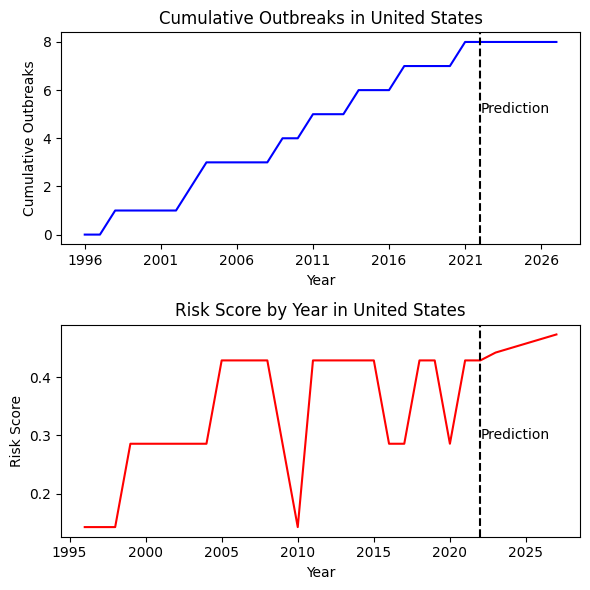

In [56]:
COUNTRY = 'United States'
import random
countries_subset = random.sample(list(df1['Country'].unique()), 5)
plot_data(COUNTRY)
# Uncomment to get a random sample of graphs
# for country in countries_subset:
#     plot_data(country)

## Differences
Let's see which countries show a significant difference in trend between the logistic model and our model.

In [57]:
def pos_or_neg(num):
    if num < 0:
        return 'a downward'
    return 'an upward'
outbreak_trend_df
count_lines = 0
for country in risk_trend_df['Country']:
    risk_trend = risk_trend_df[risk_trend_df['Country'] == country]['Trends'].iloc[0]
    outbreak_trend = outbreak_trend_df[outbreak_trend_df['Country'] == country]['Trend'].iloc[0]
    if (risk_trend * outbreak_trend) < 0 and count_lines < 10:
        print(f"{country} has {pos_or_neg(outbreak_trend)} outbreak trend but {pos_or_neg(risk_trend)} risk score trend")
        count_lines += 1

United Kingdom has a downward outbreak trend but an upward risk score trend
Australia has a downward outbreak trend but an upward risk score trend
Chile has a downward outbreak trend but an upward risk score trend
Slovenia has a downward outbreak trend but an upward risk score trend
Marshall Islands has a downward outbreak trend but an upward risk score trend
Fiji has a downward outbreak trend but an upward risk score trend
United Arab Emirates has a downward outbreak trend but an upward risk score trend
Austria has a downward outbreak trend but an upward risk score trend
Chad has a downward outbreak trend but an upward risk score trend
Guatemala has a downward outbreak trend but an upward risk score trend


## Comparison Heat Maps

In [58]:
# Let's visualize this with some maps
risk_trend_df['Country'] = risk_trend_df['Country'].apply(lambda x: country_codes[x])
outbreak_trend_df['Country'] = outbreak_trend_df['Country'].apply(lambda x: country_codes[x])
risk_trend_df.columns = ['Country', 'Trend']

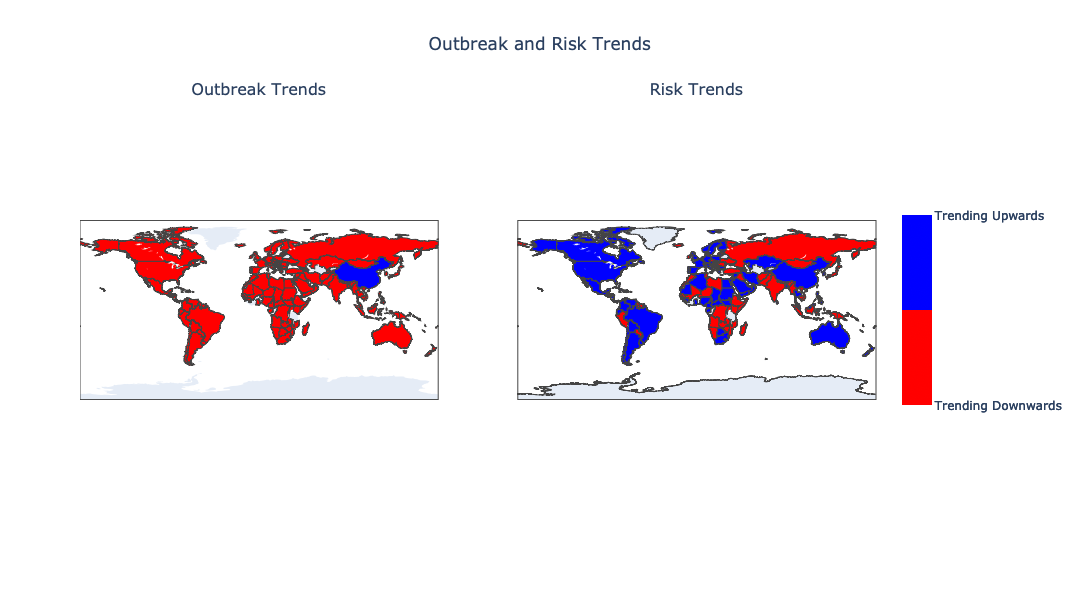

In [59]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Outbreak Trends', 'Risk Trends'),
                    specs=[[{"type": "choropleth"}, {"type": "choropleth"}]])

# Function to return 1 for positive trend and 0 for negative
def trend_binary(value):
    return 1 if value > 0 else 0

# Custom discrete colorscale
discrete_colorscale = [(0, 'red'), (0.5, 'red'), (0.5, 'blue'), (1, 'blue')]

# Adjustments for colorbar layout to avoid overlapping titles
colorbar_layout = dict(
    tickvals=[0, 1],
    ticktext=['Trending Downwards', 'Trending Upwards'],
    len=0.5,  # Adjust length of colorbar
)

# Outbreak Trends Choropleth
outbreak_trace = go.Choropleth(
    locations=outbreak_trend_df['Country'],
    z=outbreak_trend_df['Trend'].apply(trend_binary),
    text=outbreak_trend_df['Country'],
    colorscale=discrete_colorscale,
    locationmode='ISO-3',
    colorbar=colorbar_layout
)
fig.add_trace(outbreak_trace, row=1, col=1)

# Risk Trends Choropleth
risk_trace = go.Choropleth(
    locations=risk_trend_df['Country'],
    z=risk_trend_df['Trend'].apply(trend_binary),
    text=risk_trend_df['Country'],
    colorscale=discrete_colorscale,
    locationmode='ISO-3',
    colorbar=colorbar_layout
)
fig.add_trace(risk_trace, row=1, col=2)

# Update layout
fig.update_layout(
    title_text='Outbreak and Risk Trends',
    title_x=0.5,
    geo=dict(
        showframe=True,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    width=1200,
    height=600
)

fig.show()

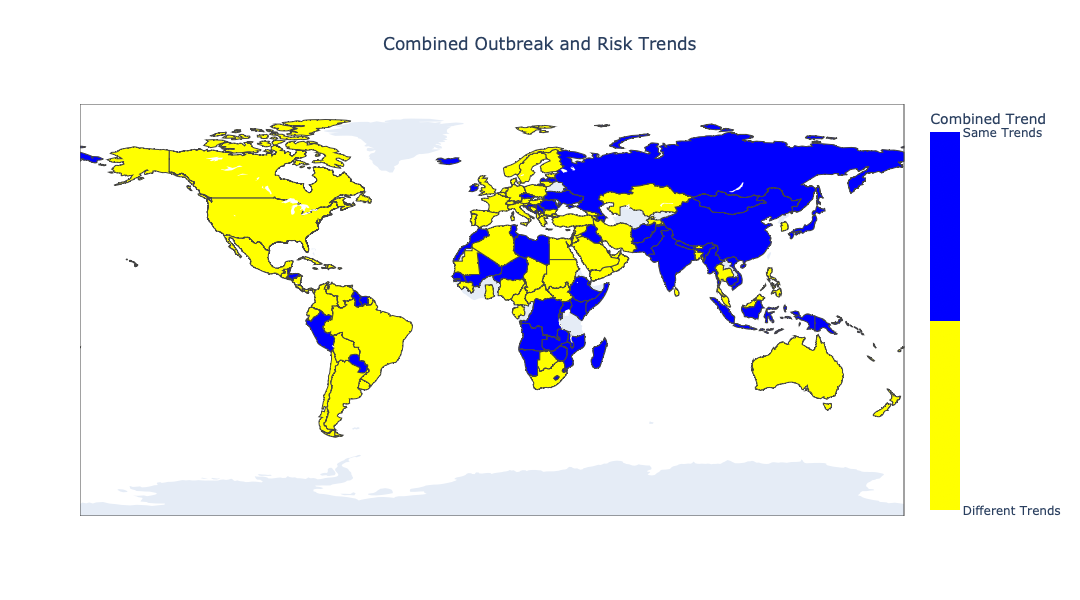

In [60]:
# Let's combine these into a single map
combined_df = pd.merge(outbreak_trend_df, risk_trend_df, on='Country', suffixes=('_outbreak', '_risk'))

def compare_trends(trend1, trend2):
    return 1 if trend1 * trend2 > 0 else 0

# Creating a new column for the combined trend
combined_df['Combined Trend'] = combined_df.apply(lambda row: compare_trends(row['Trend_outbreak'], row['Trend_risk']), axis=1)

# Discrete colorscale
discrete_colorscale = [(0, 'yellow'), (0.5, 'yellow'), (0.5, 'blue'), (1, 'blue')]

fig = go.Figure(go.Choropleth(
    locations=combined_df['Country'],
    z=combined_df['Combined Trend'],
    text=combined_df['Country'],
    colorscale=discrete_colorscale,
    colorbar_title="Combined Trend",
    locationmode='ISO-3',
    colorbar=dict(
        tickvals=[0, 1],
        ticktext=['Different Trends', 'Same Trends']
    )
))

fig.update_layout(
    title_text='Combined Outbreak and Risk Trends',
    title_x=0.5,
    geo=dict(
        showframe=True,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    width=800,
    height=600
)

fig.show()

So it is clear that there is some substantial disagreement between the two models. For the sake of informing the public health community, let's go back to our random forest classifier to see if we can better understand what is informing our model. We choose this model because it had comparable results to Knn and has defined feature importances (unlike knn).

In [61]:
feature_importances = best_rf_classifier.feature_importances_
feature_names = pivot_df.columns[:-1]  # Assuming the last column is the target column

feature_importance_tuples = [(feature_name, importance) for feature_name, importance in zip(feature_names, feature_importances)]

feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

top_4_features = feature_importance_tuples[:4]

for feature, importance in top_4_features:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Recent Outbreak, Importance: 0.09709965966205478
Feature: People practicing open defecation (% of population), Importance: 0.08686711314241623
Feature: Prevalence of undernourishment (% of population), Importance: 0.08641988077317447
Feature: People using safely managed sanitation services (% of population), Importance: 0.07894544475791444


# Conclusions
We found that our best model which fits well with the data also defies the forecast offered by simply looking at the number of outbreaks over time. This supports our hypothesis that the number of outbreaks is dependent on wider factors such as population changes health infrastructure, and the prevalence of agriculture. I believe that our map can be used to better investigate countries where the next big zoonotic outbreak will come from.

# Test Your Browser
If the following plot is not rendering for you then it is most likely an issue with your browser. We tested this on Firefox and Edge and Chrome and noticed that Chrome tended to have the most issues.

## Test Rendering

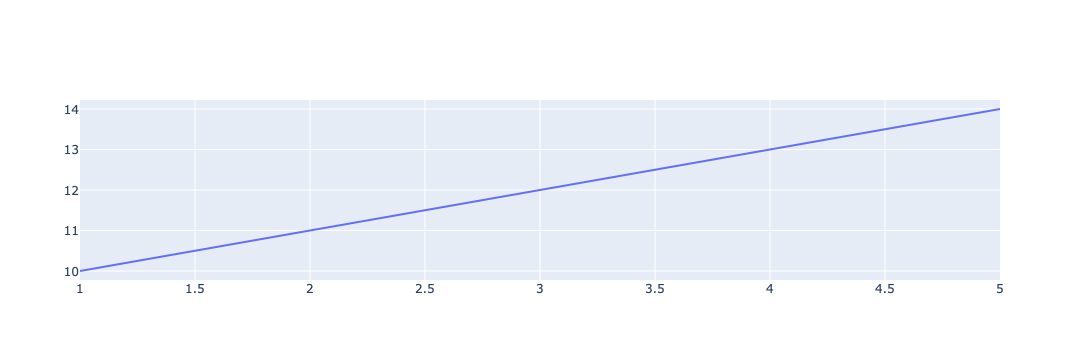

In [62]:
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Sample data
x = [1, 2, 3, 4, 5]
y = [10, 11, 12, 13, 14]

# Create a basic line chart
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))

# Display the figure
fig.show()


## Test Widgets
The widgets are also interfered with by the browser so run the below cell to see if your browser renders the widgets properly

In [63]:
dropdown = widgets.Dropdown(options=countries, description='Country:')
output = widgets.interactive_output(plot_data, {'country': dropdown})
display(dropdown, output)


Dropdown(description='Country:', options=('Afghanistan', 'Mali', 'United Kingdom', 'Australia', 'Chile', 'Slov…

Output()

![University of Michigan Logo](https://brand.umich.edu/assets/brand/style-guide/logo-guidelines/U-M_Logo-Horizontal-Hex.png)